In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5),
                                     (0.5, 0.5, 0.5))
])


trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
import torch
import math

class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T

    def beta(self, t):
        # t in [0,1], shape [B]
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def int_beta(self, t):
        # integral up to t for a linear beta
        return self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2

    def alpha(self, t):
        # exp of - integral see calculations in pdf
        return torch.exp(-0.5 * self.int_beta(t))

    def sigma(self, t):
        a = self.alpha(t)
        return torch.sqrt(1.0 - a*a).clamp(min=1e-5)

    def diffusion(self, t):
        return torch.sqrt(self.beta(t)).clamp(min=1e-5)

    def drift(self, x, t):
        b = self.beta(t).view(-1, 1, 1, 1)
        return -0.5 * b * x


In [ ]:
import torch
import torch.nn as nn

class TimeEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(
            torch.arange(half_dim, device=t.device) * -(torch.log(torch.tensor(10000.0, device=t.device)) / half_dim)
        )
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return self.lin(emb)  # [B, dim]


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, groups=32):
        super().__init__()
        # groups must divide out_ch. For 128,256,512,1024 channels, 32 works.
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(groups, out_ch),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(groups, out_ch),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


In [ ]:
class SelfAttention2d(nn.Module): # the attention blocks we add during the downward
    def __init__(self, channels, num_heads=4):
        super().__init__()
        assert channels % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5

        self.norm = nn.GroupNorm(32, channels)
        self.qkv = nn.Conv2d(channels, 3 * channels, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        """
        x: [B, C, H, W]
        attention over HW tokens
        """
        B, C, H, W = x.shape
        h = self.norm(x)

        qkv = self.qkv(h)                        
        q, k, v = qkv.chunk(3, dim=1)            

        # just reshaping for the heads
        q = q.view(B, self.num_heads, self.head_dim, H * W)  # [B, heads, dim, N]
        k = k.view(B, self.num_heads, self.head_dim, H * W)
        v = v.view(B, self.num_heads, self.head_dim, H * W)

        # attention: (q^T k) complexity so training is longer !!! 
        q = q.permute(0, 1, 3, 2)                                # [B, heads, N, dim]
        k = k.permute(0, 1, 2, 3)                                # [B, heads, dim, N]
        attn = (q @ k) * self.scale                               # [B, heads, N, N]
        attn = attn.softmax(dim=-1)

        v = v.permute(0, 1, 3, 2)                                # [B, heads, N, dim]
        out = attn @ v                                            # [B, heads, N, dim]
        out = out.permute(0, 1, 3, 2).contiguous()                # [B, heads, dim, N]
        out = out.view(B, C, H, W)                                # [B, C, H, W]

        out = self.proj(out)
        return x + out                                            


In [ ]:
class UNetScoreCIFAR3Level_Attn(nn.Module):
    def __init__(self, time_dim=32, base_channels=128, img_channels=3, attn_heads=4):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)
        in_ch = img_channels + time_dim

        C = base_channels

        # Encoder 
        self.down1 = ConvBlock(in_ch, C)       
        self.pool1 = nn.MaxPool2d(2)            

        self.down2 = ConvBlock(C, 2*C)          
        self.pool2 = nn.MaxPool2d(2)            

        self.down3 = ConvBlock(2*C, 4*C)        
        self.attn8 = SelfAttention2d(4*C, num_heads=attn_heads)  
        self.pool3 = nn.MaxPool2d(2)            

        # -------- Bottleneck --------
        self.bottleneck = ConvBlock(4*C, 8*C)   
        self.attn4 = SelfAttention2d(8*C, num_heads=attn_heads)  

        # -------- Decoder --------
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(8*C, 4*C, 3, padding=1),
        )
        self.dec3 = ConvBlock(8*C, 4*C)

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(4*C, 2*C, kernel_size=3, padding=1),
        )
        self.dec2 = ConvBlock(4*C, 2*C)

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(2*C, C, kernel_size=3, padding=1),
        )
        self.dec1 = ConvBlock(2*C, C)

        self.out_conv = nn.Conv2d(C, img_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        emb = self.time_mlp(t)                   # [B, time_dim]
        emb = emb[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, emb], dim=1)

        d1 = self.down1(x_in)                   
        p1 = self.pool1(d1)                      

        d2 = self.down2(p1)                     
        p2 = self.pool2(d2)                      

        d3 = self.down3(p2)                      
        d3 = self.attn8(d3)                      # attention at 8x8
        p3 = self.pool3(d3)                      

        b = self.bottleneck(p3)                 
        b = self.attn4(b)                        # attention at 4x4

        u3 = self.up3(b)                         
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.dec3(u3)

        u2 = self.up2(u3)                        
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.dec2(u2)

        u1 = self.up1(u2)                        
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.dec1(u1)

        return self.out_conv(u1)


In [ ]:
@torch.no_grad()
def vp_sample_xt(x0, t, sde): # conditional sampling of x_t given x_0 we can easily do since it's gaussian see calculations
    """
    x0: [B,3,32,32], t: [B]
    returns xt, eps where xt = alpha x0 + sigma eps
    """
    a = sde.alpha(t).view(-1, 1, 1, 1)
    s = sde.sigma(t).view(-1, 1, 1, 1)
    eps = torch.randn_like(x0)
    xt = a * x0 + s * eps
    return xt, eps


In [ ]:
import os
import torch
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu" # absolutely vital to not live through the heat death of the universe during training

ckpt_path = "vp_cifar_ckpt_att.pth"

time_dim = 32
base_channels = 128 # 128 channels is a good start see if we have to increase 
img_channels = 3 # 3 for RGB 

beta_min = 0.1
beta_max = 20.0
T = 1.0

lr = 1e-5 # tweak lr as learning advances
weight_decay = 1e-4

ema_decay = 0.999 # moving average on the weights of the NN its the coeff in the exp for the ema
t_min = 1e-4

num_epochs_total = 200      # total epochs to do tweak if needed
save_every = 10 # to not lose everything in case of problems we have a .pth that is progressively updated WITH the optimizer to resume training


@torch.no_grad()
def update_ema(ema_model, model, decay):
    for p_ema, p in zip(ema_model.parameters(), model.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1 - decay)


model = UNetScoreCIFAR3Level_Attn(time_dim=time_dim, base_channels=base_channels, img_channels=img_channels).to(device)
ema_model = UNetScoreCIFAR3Level_Attn(time_dim=time_dim, base_channels=base_channels, img_channels=img_channels).to(device)

sde = VPSDE(beta_min=beta_min, beta_max=beta_max, T=T)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# resume training from existing file if possible
start_epoch = 0
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)

    model.load_state_dict(ckpt["model_state"])
    ema_model.load_state_dict(ckpt["ema_state"])

    if "optimizer_state" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state"])

    if "beta_min" in ckpt and "beta_max" in ckpt and "T" in ckpt:
        sde = VPSDE(beta_min=float(ckpt["beta_min"]), beta_max=float(ckpt["beta_max"]), T=float(ckpt["T"]))

    start_epoch = int(ckpt.get("epoch", -1)) + 1

    # IMPORTANT: optimizer state restores old LR; overwrite with desired LR
    for g in optimizer.param_groups:
        g["lr"] = lr
        g["weight_decay"] = weight_decay

    print(f"Resuming from {ckpt_path} at epoch {start_epoch} (lr={optimizer.param_groups[0]['lr']})")

else:
    # start fresh
    ema_model.load_state_dict(model.state_dict())
    print(f"No checkpoint found at {ckpt_path}. Starting fresh at epoch 0 (lr={lr}).")


# ---- training ----
end_epoch = num_epochs_total

for epoch in range(start_epoch, end_epoch):
    model.train()
    epoch_loss = 0.0
    n_batches = 0

    for x0, _ in loader:
        x0 = x0.to(device)

        # t ~ Uniform(t_min, 1)
        t = t_min + (1.0 - t_min) * torch.rand(x0.size(0), device=device)

        xt, eps = vp_sample_xt(x0, t, sde)
        eps_pred = model(xt, t) # wwe do the eps pred and not the score pred anymore

        loss = F.mse_loss(eps_pred, eps)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        update_ema(ema_model, model, ema_decay)

        epoch_loss += loss.item()
        n_batches += 1

    mean_loss = epoch_loss / max(n_batches, 1)
    print(f"Epoch {epoch+1}/{end_epoch}: mean loss = {mean_loss:.4f}")

    # ---- checkpoint ----
    if (epoch + 1) % save_every == 0 or (epoch + 1) == end_epoch:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "ema_state": ema_model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "beta_min": sde.beta_min,
                "beta_max": sde.beta_max,
                "T": sde.T,
                "time_dim": time_dim,
                "base_channels": base_channels,
                "img_channels": img_channels,
                "t_min": t_min,
            },
            ckpt_path,
        )
        print(f"Checkpoint saved at epoch {epoch+1} → {ckpt_path}")


Resuming from vp_cifar_ckpt_att.pth at epoch 100 (lr=3e-05)
Epoch 101/150: mean loss = 0.0303
Epoch 102/150: mean loss = 0.0304
Epoch 103/150: mean loss = 0.0306
Epoch 104/150: mean loss = 0.0307
Epoch 105/150: mean loss = 0.0298
Epoch 106/150: mean loss = 0.0306
Epoch 107/150: mean loss = 0.0305
Epoch 108/150: mean loss = 0.0301
Epoch 109/150: mean loss = 0.0300
Epoch 110/150: mean loss = 0.0300
Checkpoint saved at epoch 110 → vp_cifar_ckpt_att.pth
Epoch 111/150: mean loss = 0.0305
Epoch 112/150: mean loss = 0.0303
Epoch 113/150: mean loss = 0.0303
Epoch 114/150: mean loss = 0.0299
Epoch 115/150: mean loss = 0.0301
Epoch 116/150: mean loss = 0.0301
Epoch 117/150: mean loss = 0.0306
Epoch 118/150: mean loss = 0.0303
Epoch 119/150: mean loss = 0.0303
Epoch 120/150: mean loss = 0.0298
Checkpoint saved at epoch 120 → vp_cifar_ckpt_att.pth
Epoch 121/150: mean loss = 0.0300
Epoch 122/150: mean loss = 0.0301
Epoch 123/150: mean loss = 0.0310
Epoch 124/150: mean loss = 0.0304
Epoch 125/150: m

In [ ]:
@torch.no_grad()
def sample_prob_flow_heun_eps(model, sde, num_steps=1000, batch_size=16, device="cuda", t_min=1e-4):
    """
    Heun (RK2) solver for VP probability-flow ODE using epsilon-prediction model.
    """
    model.eval()

    t_grid = torch.linspace(1.0, t_min, num_steps, device=device)

    x = torch.randn(batch_size, 3, 32, 32, device=device)

    def ode_drift(x, t_scalar):
        # t_scalar: scalar tensor
        t = torch.full((x.size(0),), t_scalar, device=device)
        beta = sde.beta(t).view(-1, 1, 1, 1)
        sigma = sde.sigma(t).view(-1, 1, 1, 1)

        eps = model(x, t)
        return (-0.5 * beta * x) + (0.5 * beta * eps / sigma)

    for i in range(num_steps - 1):
        t0 = t_grid[i]
        t1 = t_grid[i + 1]
        dt = t1 - t0  # negative

        k1 = ode_drift(x, t0)
        x_pred = x + dt * k1

        k2 = ode_drift(x_pred, t1)

        # Heun update
        x = x + 0.5 * dt * (k1 + k2)

    return x

In [ ]:
import matplotlib.pyplot as plt
import math

def show_cifar_grid(x, nrow=4, title="Samples"): # just visualization
    x = x.detach().cpu()
    x = (x.clamp(-1, 1) + 1) / 2.0  # -> [0,1]
    B = x.size(0)
    ncol = math.ceil(B / nrow)

    plt.figure(figsize=(ncol*2, nrow*2))
    for i in range(B):
        plt.subplot(nrow, ncol, i+1)
        img = x[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [12]:
time_dim = 32
base_channels = 128
img_channels = 3

beta_min = 0.1
beta_max = 20.0
T = 1.0

lr = 3e-5
weight_decay = 1e-4

ema_decay = 0.999
t_min = 1e-4

num_epochs_total = 150      # total epochs you want to reach
save_every = 10

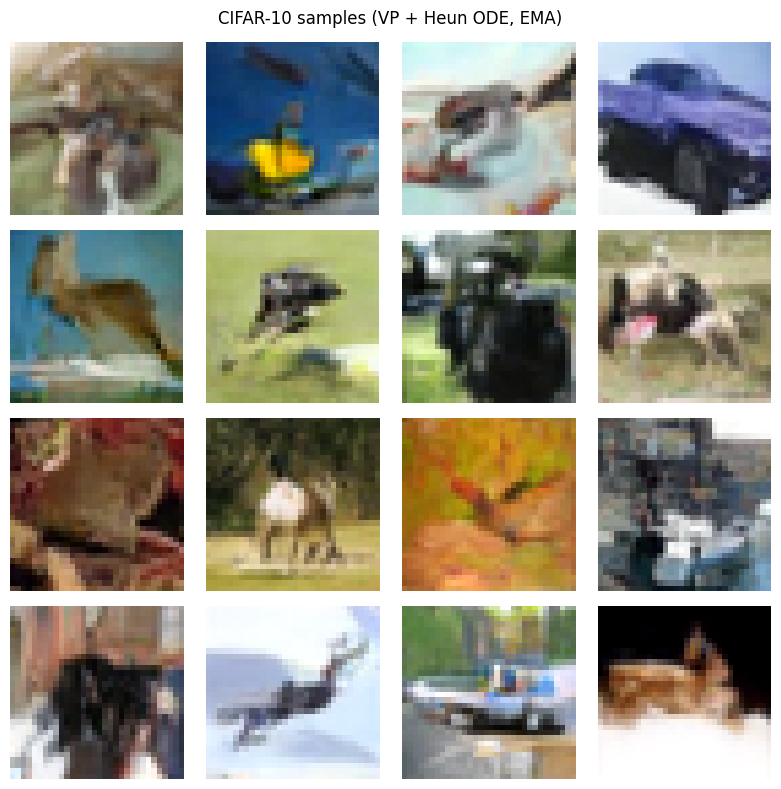

In [16]:
samples = sample_prob_flow_heun_eps(ema_model, sde, num_steps=4000, batch_size=16, device=device, t_min=1e-4)
show_cifar_grid(samples, nrow=4, title="CIFAR-10 samples (VP + Heun ODE, EMA)")


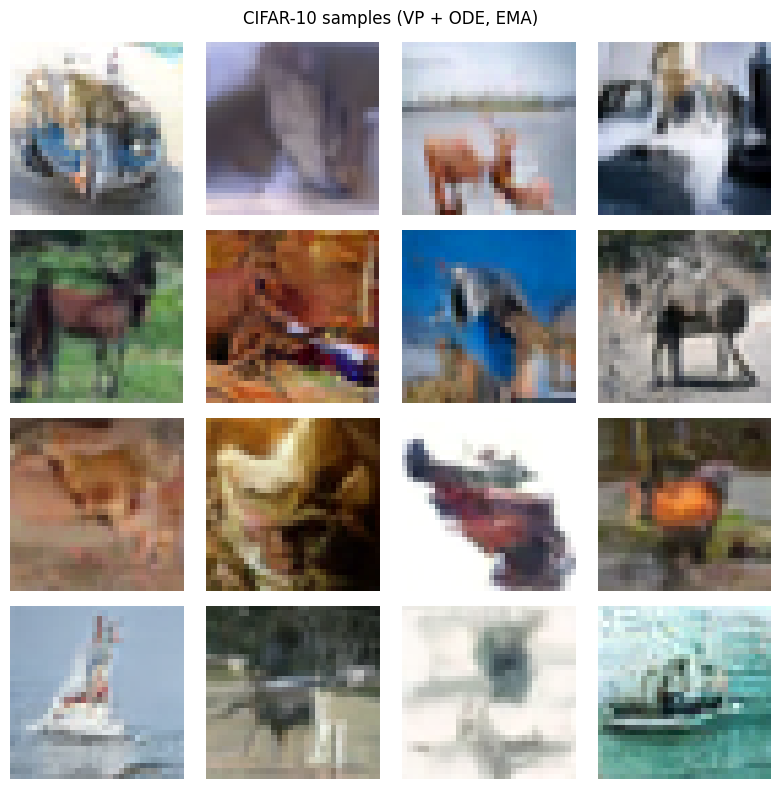

In [13]:
sde = VPSDE(beta_min=beta_min, beta_max=beta_max, T=T)
model = UNetScoreCIFAR3Level_Attn(time_dim=time_dim, base_channels=base_channels, img_channels=img_channels).to(device)
ema_model = UNetScoreCIFAR3Level_Attn(time_dim=time_dim, base_channels=base_channels, img_channels=img_channels).to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt_path = "vp_cifar_ckpt_att.pth"
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
ema_model.load_state_dict(ckpt["ema_state"])
samples = sample_prob_flow_ode(ema_model, sde, num_steps=4000, batch_size=16, device=device, t_min=1e-4)
show_cifar_grid(samples, nrow=4, title="CIFAR-10 samples (VP + ODE, EMA)")
